# Online Joint State and Parameter Estimation for AR SSM (noises' variances are known) 
State space model
\begin{align*}
    &\mathbf{x}_t = \mathbf{A}\mathbf{x}_{t-1} + \mathbf{p}_t \quad \mathbf{p}_t \sim \mathcal{N}(\mathbf{0}, \mathbf{I}\gamma_x^{-1}) \\
    &y_t = \mathbf{c}^\text{T}\mathbf{x}_t + m_t \quad v_t \sim \mathcal{N}(0, \gamma_y^{-1})
\end{align*}

or

\begin{align*}
     &p(\mathbf{x}_t\,|\,\mathbf{x}_{t-1},\mathbf{a},\gamma) = \mathcal{N}\left(\mathbf{x}_t\;\middle|\; \mathbf{A}\mathbf{x}_{t-1},  \mathbf{I}\gamma_x^{-1} \right)\\
    &p(y_t\,|\,\mathbf{x}_{t}) = \mathcal{N}\left(y_t \;\middle|\;\mathbf{c}^\text{T}\mathbf{x}_t, \gamma_y^{-1} \right)
\end{align*}

where
\begin{align*}
    &\mathbf{x}_t = (x_t, x_{t-1}, \dots, x_{t-p+1})^\text{T} \quad \mathbf{x}_{t-1} = (x_{t-1}, x_{t-2}, \dots, x_{t-p})^\text{T} 
    \\ \\
    &\mathbf{A} = 
    \begin{bmatrix}
        a_1 & a_2 & a_3 & \dots & a_p \\
        1 & 0 & 0 & \dots & 0 \\ 
        0 & 1 & 0 & \dots & 0 \\   
        \vdots & \vdots & \vdots & \ddots & \vdots \\
        0 & 0 & 0 & \dots & 0
    \end{bmatrix}
    =
    \begin{bmatrix}
         \mathbf{a}^\text{T} \\
         \mathbf{I}_{p-1} \quad \mathbf{0}
    \end{bmatrix}
    \\ \\
    &\mathbf{I} = \mathbf{I}_p = 
    \begin{bmatrix}
        1 & 0 & 0 & \dots & 0 \\ 
        0 & 1 & 0 & \dots & 0 \\   
        \vdots & \vdots & \vdots & \ddots & \vdots \\
        0 & 0 & 0 & \dots & 1
    \end{bmatrix} \\
\end{align*}

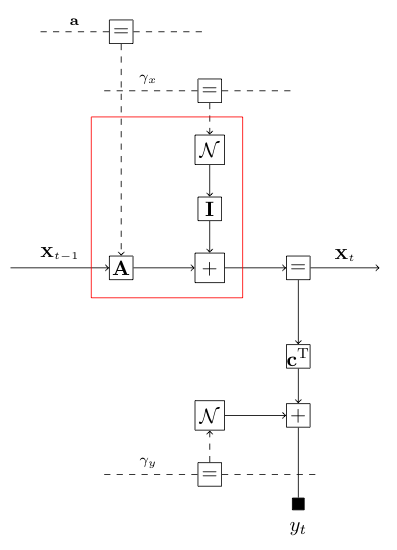

In [1]:
using Images
img = load("../ffgs/AR-online.png")

The central quantity of our interest is a joint estimation of the AR coefficients $\mathbf{a}$ and states $\mathbf{x}_n$, while setting noises' precisions $\gamma_x=1$, $\gamma_y=\frac{1}{2}$.

In [2]:
using ProgressMeter
using Revise
using ForneyLab
using Plots
using Random
include( "../AR-node/autoregression.jl")
include("../AR-node/rules_prototypes.jl")
include("../AR-node/vmp_rules.jl")
# helpers for evaluation of the model
include("../helpers/functions.jl")
# module to generate data for AR
include("../data/ARdata.jl")
import Main.ARdata: loadAR, generateAR, writeAR, readAR
import LinearAlgebra.I, LinearAlgebra.Symmetric
import ForneyLab: unsafeCov, unsafeMean, unsafePrecision

In [90]:
Random.seed!(42)

# Define the order and data
ARorder = 2
diagAR(dim) = Matrix{Float64}(I, dim, dim)

# AR data
a_w, b_w = 1, 1 
v_x = b_w/a_w # process noise variance
coefs, data = generateAR(1000, ARorder, nvar=v_x)
#x = loadAR("../data/temperature.csv", ARorder, col=:Temp)
#coefs, data = generate_sin(1000, tiny)
# writeAR(coefs, x, folder="../data")
#coefs, x = readAR("../data/AR(2).csv")

# Remove t-1 samples from x
x = [x[1] for x in data[2:end]]

v_y = 2 # measurement noise variance
# Observations
y = [x + sqrt(v_y)*randn() for x in x];

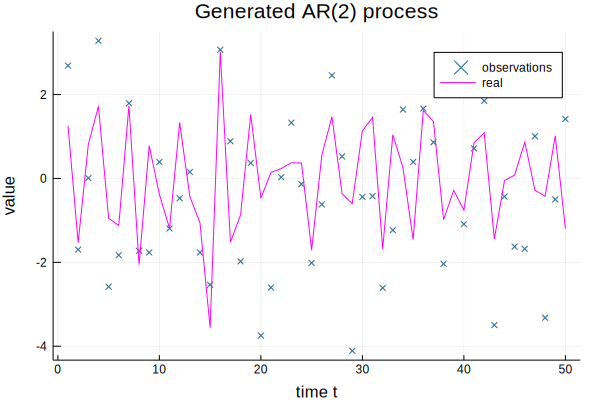

In [91]:
# Plotting the data
from = 1; to = 50;
scatter(y[from:to], markershape = :xcross, markeralpha = 0.6,
        markersize = 2, xlabel="time t", ylabel="value", label="observations")
plot!(x[from:to], color=:magenta, label="real", title="Generated AR($ARorder) process")

In [92]:
# Building the model
g = FactorGraph()

# declare priors as random variables
@RV m_x_t_prev
@RV w_x_t_prev
@RV m_a_t
@RV w_a_t
@RV m_y_t

@RV a ~ GaussianMeanPrecision(m_a_t, w_a_t)
@RV x_t_prev ~ GaussianMeanPrecision(m_x_t_prev, w_x_t_prev)
@RV w ~ Gamma(a_w, b_w)
@RV x_t = AR(a, x_t_prev, w)
c = zeros(ARorder); c[1] = 1.0
@RV y_t ~ GaussianMeanPrecision(m_y_t, v_y^-1)
DotProduct(y_t, c, x_t)

# Placeholders for prior
placeholder(m_x_t_prev, :m_x_t_prev, dims=(ARorder,))
placeholder(w_x_t_prev, :w_x_t_prev, dims=(ARorder, ARorder))
placeholder(m_a_t, :m_a_t, dims=(ARorder,))
placeholder(w_a_t, :w_a_t, dims=(ARorder, ARorder))

# Placeholder for data
placeholder(m_y_t, :m_y_t)

ForneyLab.draw(g)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 5342355981287428530 -->
 
 5342355981287428530 
 
 𝒩 
 gaussianmeanprecision_2 
 
<!-- 12320463734886325488 -->
 
 12320463734886325488 
 
 Gam 
 gamma_1 
 
<!-- 14959009270378701250 -->
 
 14959009270378701250 
 
 clamp_2 
 
<!-- 12320463734886325488--14959009270378701250 -->
 
 12320463734886325488--14959009270378701250 
 
 clamp_2 
 1 out 
 3 b 
 
<!-- 16507748411880969984 -->
 
 16507748411880969984 
 
 clamp_1 
 
<!-- 12320463734886325488--16507748411880969984 -->
 
 12320463734886325488--16507748411880969984 
 
 clamp_1 
 1 out 
 2 a 
 
<!-- 641234836836810511 -->
 
 641234836836810511 
 
 placeholder_m_y_t 
 
<!-- 1464299709353829311 -->
 
 1464299709353829311 
 
 𝒩 
 gaussianmeanprecision_3 
 
<!-- 641234836836810511--1464299709353829311 -->
 
 641234836836810511--1464299709353829311 
 
 m_y_t 
 2 m 
 1 out 
 
<!-- 3039431180313334759 -->
 
 3039431180313334759 
 
 placeholder_w_a_t 
 
<!-- 5701575786835857579 -->
 
 5701575786835857579 
 
 𝒩 
 gaussianmeanprecision_1 
 
<!-- 3039431180313334759--5701575786835857579 -->
 
 3039431180313334759--5701575786835857579 
 
 w_a_t 
 3 w 
 1 out 
 
<!-- 6913404430848988113 -->
 
 6913404430848988113 
 
 clamp_3 
 
<!-- 1464299709353829311--6913404430848988113 -->
 
 1464299709353829311--6913404430848988113 
 
 clamp_3 
 1 out 
 3 w 
 
<!-- 8396948493984004971 -->
 
 8396948493984004971 
 
 dot 
 dotproduct_1 
 
<!-- 8396948493984004971--1464299709353829311 -->
 
 8396948493984004971--1464299709353829311 
 
 y_t 
 1 out 
 1 out 
 
<!-- 10493683700597299726 -->
 
 10493683700597299726 
 
 Autoregression 
 autoregression_1 
 
<!-- 8396948493984004971--10493683700597299726 -->
 
 8396948493984004971--10493683700597299726 
 
 x_t 
 1 out 
 3 in2 
 
<!-- 7458539830844790177 -->
 
 7458539830844790177 
 
 clamp_4 
 
<!-- 8396948493984004971--7458539830844790177 -->
 
 8396948493984004971--7458539830844790177 
 
 clamp_4 
 1 out 
 2 in1 
 
<!-- 11416848455798608938 -->
 
 11416848455798608938 
 
 placeholder_m_a_t 
 
<!-- 11416848455798608938--5701575786835857579 -->
 
 11416848455798608938--5701575786835857579 
 
 m_a_t 
 2 m 
 1 out 
 
<!-- 9452406060954340988 -->
 
 9452406060954340988 
 
 placeholder_m_x_t_prev 
 
<!-- 9452406060954340988--5342355981287428530 -->
 
 9452406060954340988--5342355981287428530 
 
 m_x_t_prev 
 2 m 
 1 out 
 
<!-- 10493683700597299726--5342355981287428530 -->
 
 10493683700597299726--5342355981287428530 
 
 x_t_prev 
 1 out 
 2 x 
 
<!-- 10493683700597299726--12320463734886325488 -->
 
 10493683700597299726--12320463734886325488 
 
 w 
 1 out 
 4 W 
 
<!-- 10493683700597299726--5701575786835857579 -->
 
 10493683700597299726--5701575786835857579 
 
 a 
 1 out 
 3 a 
 
<!-- 177080690913665038 -->
 
 177080690913665038 
 
 placeholder_w_x_t_prev 
 
<!-- 177080690913665038--5342355981287428530 -->
 
 177080690913665038--5342355981287428530 
 
 w_x_t_prev 
 3 w 
 1 out

In [93]:
# Specify recognition factorization
q = RecognitionFactorization(a, x_t, ids=[:A :X_t])

# Generate the variational update algorithms for each recognition factor
algo = variationalAlgorithm(q)

# Load algorithms
eval(Meta.parse(algo))

stepX_t! (generic function with 3 methods)

In [94]:
# Define values for prior statistics
m_a_0 = zeros(ARorder)
w_a_0 = diagAR(ARorder)
m_x_prev_0 = zeros(ARorder)
w_x_prev_0 = diagAR(ARorder)

# Storage
m_x = Vector{Vector{Float64}}(undef, length(y))
w_x = Vector{Array{Float64, 2}}(undef, length(y))
m_a = Vector{Vector{Float64}}(undef, length(y))
w_a = Vector{Array{Float64, 2}}(undef, length(y))

# Inits
m_x_t_prev_min = m_x_prev_0
w_x_t_prev_min = w_x_prev_0
m_a_min = m_a_0
w_a_min = w_a_0;

In [95]:
data = Dict()
marginals = Dict()
n_its = 5

# Storage for scores
WMSEs = []
logPDFs = []

p = Progress(length(y), 1, "Observed ")
for t in 1:length(y)
    update!(p, t)
    marginals[:a] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=m_a_min, w=w_a_min)
    marginals[:x_t_prev] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=m_x_t_prev_min, w=w_x_t_prev_min)
    marginals[:w] = ProbabilityDistribution(Univariate, Gamma, a=a_w, b=b_w)
    global m_x_t_prev_min, w_x_t_prev_min, m_a_t_min, w_a_t_min

    for i = 1:n_its
        data = Dict(:m_y_t => y[t],
                    :m_a_t => m_a_min,
                    :w_a_t => w_a_min,
                    :m_x_t_prev => m_x_t_prev_min,
                    :w_x_t_prev => w_x_t_prev_min)
        
        stepX_t!(data, marginals)
        stepA!(data, marginals)
        m_a[t] = unsafeMean(marginals[:a])
        w_a[t] = unsafePrecision(marginals[:a])
        m_x[t] = unsafeMean(marginals[:x_t])
        w_x[t] = unsafePrecision(marginals[:x_t])
        m_a_min = m_a[t]
        w_a_min = w_a[t]
        m_x_t_prev_min = m_x[t]
        w_x_t_prev_min = w_x[t]
    end
    push!(WMSEs, wmse(x[1:t], [est[1] for est in m_x[1:t]], [est[1]^-1 for est in w_x[1:t]]))
    push!(logPDFs, logPDF(x[t], m_x[t][1], w_x[t][1]^-1))
end

In [96]:
# Extracting estimates for x_t (first component of vector x̄_t) for plotting
m_ar = [m_x[1] for m_x in [m_x[1] for m_x in m_x[1:end]]]
v_ar = [v_x[1]^-1 for v_x in [v_x[1][1] for v_x in w_x[1:end]]];

In [97]:
# Estimations
println("Coefs\n=========")
println("Estimated ", mean(marginals[:a]))
println("True ", coefs)

println("\nState\n=========")
println("Mean ", mean(marginals[:x_t]))
println("Var ", unsafeCov(marginals[:x_t]))

Coefs
Estimated [-0.0654499, -0.0355223]
True [-0.556027, -0.444383]

State
Mean [0.370715, -0.652602]
Var [0.666667 -0.0; -0.0 1.0]


# Random walk model 
As a benchamrk, we use the following RW model.
\begin{align*}
    &x_t = x_{t-1} + p_t \quad p_t \sim \mathcal{N}(0, \gamma_x^{-1}) \\
    &y_t = x_t + m_t \quad m_t \sim \mathcal{N}(0, \gamma_y^{-1})
\end{align*}

We set $\gamma_y = 10.0$ and $\gamma_y = \frac{1}{2}$

In [98]:
rwg = FactorGraph()

# declare priors as random variables
@RV m_x_t_min
@RV w_x_t_min
@RV x_t_min ~ GaussianMeanPrecision(m_x_t_min, w_x_t_min)

@RV n_t ~ GaussianMeanPrecision(0.0, v_x^-1)
@RV x_t = x_t_min + n_t
@RV m_t ~ GaussianMeanPrecision(0.0, v_y^-1)
@RV y_t = x_t + m_t

# Placeholders for prior
placeholder(m_x_t_min, :m_x_t_min)
placeholder(w_x_t_min, :w_x_t_min)

# Placeholder for data
placeholder(y_t, :y_t)
ForneyLab.draw(rwg)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 1982910965737621701 -->
 
 1982910965737621701 
 
 + 
 addition_1 
 
<!-- 16251096630277386874 -->
 
 16251096630277386874 
 
 𝒩 
 gaussianmeanprecision_1 
 
<!-- 1982910965737621701--16251096630277386874 -->
 
 1982910965737621701--16251096630277386874 
 
 x_t_min 
 1 out 
 2 in1 
 
<!-- 4597584967534888078 -->
 
 4597584967534888078 
 
 𝒩 
 gaussianmeanprecision_2 
 
<!-- 1982910965737621701--4597584967534888078 -->
 
 1982910965737621701--4597584967534888078 
 
 n_t 
 1 out 
 3 in2 
 
<!-- 8329999787197010290 -->
 
 8329999787197010290 
 
 placeholder_y_t 
 
<!-- 810528830622370543 -->
 
 810528830622370543 
 
 + 
 addition_2 
 
<!-- 8329999787197010290--810528830622370543 -->
 
 8329999787197010290--810528830622370543 
 
 y_t 
 1 out 
 1 out 
 
<!-- 810528830622370543--1982910965737621701 -->
 
 810528830622370543--1982910965737621701 
 
 x_t 
 1 out 
 2 in1 
 
<!-- 5045710630511214019 -->
 
 5045710630511214019 
 
 𝒩 
 gaussianmeanprecision_3 
 
<!-- 810528830622370543--5045710630511214019 -->
 
 810528830622370543--5045710630511214019 
 
 m_t 
 1 out 
 3 in2 
 
<!-- 5846300405130621935 -->
 
 5846300405130621935 
 
 clamp_3 
 
<!-- 5045710630511214019--5846300405130621935 -->
 
 5045710630511214019--5846300405130621935 
 
 clamp_3 
 1 out 
 2 m 
 
<!-- 796313379816744845 -->
 
 796313379816744845 
 
 clamp_4 
 
<!-- 5045710630511214019--796313379816744845 -->
 
 5045710630511214019--796313379816744845 
 
 clamp_4 
 1 out 
 3 w 
 
<!-- 2101044470510776948 -->
 
 2101044470510776948 
 
 clamp_1 
 
<!-- 13482466862545362648 -->
 
 13482466862545362648 
 
 clamp_2 
 
<!-- 14269275242706665623 -->
 
 14269275242706665623 
 
 placeholder_m_x_t_min 
 
<!-- 14269275242706665623--16251096630277386874 -->
 
 14269275242706665623--16251096630277386874 
 
 m_x_t_min 
 2 m 
 1 out 
 
<!-- 8057180975494533819 -->
 
 8057180975494533819 
 
 placeholder_w_x_t_min 
 
<!-- 8057180975494533819--16251096630277386874 -->
 
 8057180975494533819--16251096630277386874 
 
 w_x_t_min 
 3 w 
 1 out 
 
<!-- 4597584967534888078--2101044470510776948 -->
 
 4597584967534888078--2101044470510776948 
 
 clamp_1 
 1 out 
 2 m 
 
<!-- 4597584967534888078--13482466862545362648 -->
 
 4597584967534888078--13482466862545362648 
 
 clamp_2 
 1 out 
 3 w

In [99]:
algo = sumProductAlgorithm(x_t)
eval(Meta.parse(algo))

# Define values for prior statistics
m_x_0 = 0.0
w_x_0 = 1.0

n_samples = length(y)

m_x = Vector{Float64}(undef, n_samples)
w_x = Vector{Float64}(undef, n_samples)

m_x_t_min = m_x_0
w_x_t_min = w_x_0

# Storage for score
WMSEsRW = []
logPDFsRW = []

for t = 1:n_samples
    # Prepare data and prior statistics
    data = Dict(:y_t       => y[t],
                :m_x_t_min => m_x_t_min,
                :w_x_t_min => w_x_t_min)
    
    # Execute algorithm
    marginals = step!(data)

    # Extract posterior statistics
    m_x_t_min = mean(marginals[:x_t])
    w_x_t_min = var(marginals[:x_t])^-1
    
    # Store to buffer 
    m_x[t] = m_x_t_min
    w_x[t] = w_x_t_min
    push!(WMSEsRW, wmse(x[1:t], m_x[1:t], w_x[1]^-1))
    push!(logPDFsRW, logPDF(x[t], m_x[t][1], w_x[t][1]^-1))
end

In [100]:
# Extracting estimates for x_t (first component of vector x̄_t) for plotting
m_rw = [m_x[1] for m_x in m_x[1:end]];
v_rw = [v_x[1]^-1 for v_x in w_x[1:end]];

In [101]:
# Estimations
println("\nState\n=========")
println("Mean ", mean(marginals[:x_t]))
println("Var ", unsafeCov(marginals[:x_t]))


State
Mean -0.12534812516560467
Var 1.0


# Comparison
To assess the performance of our model, we use the following metric:
$$\sum_{i=1}^Te^{i-T}\frac{(m_{x_{k}}-x_{k})^2}{v_x}$$
where
$m_{x_{k}}$ - estimated mean of the hidden state,
$v_{x_{k}}$ - estimated variance of the hidden state,
$T$ - number of available observations

We also track log PDF, i.e.:
$$-\frac{1}{2}\log{2\pi v_x}-\frac{(m_{x_{k}}-x_{k})^2}{2v_x}$$

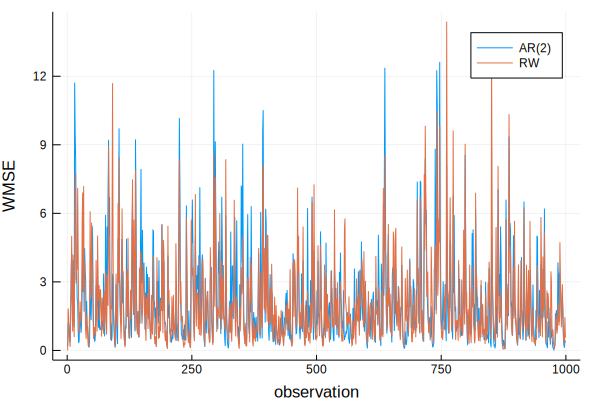

In [102]:
# Plotting
plot(WMSEs, label="AR($ARorder)")
plot!(WMSEsRW, xlabel="observation", ylabel="WMSE", label="RW")

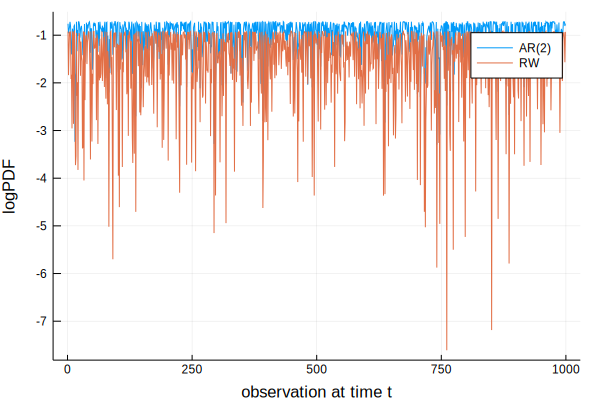

In [103]:
# log PDFs
plot(logPDFs[1:end], label="AR($ARorder)")
plot!(logPDFsRW[1:end], label="RW", xlabel="observation at time t", ylabel="logPDF")

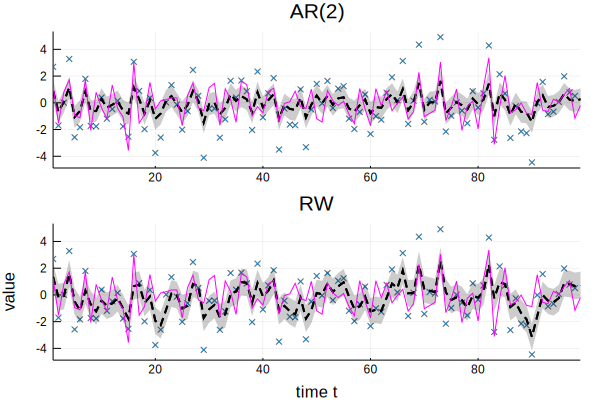

In [104]:
from = 1
upto = 99 # limit for building a graph 
scale = 1.0 # scale for the variance

scatter(y, label="noisy observations", 
        markershape = :xcross, markeralpha = 0.6,
        markersize = 2)
plot!([m_rw, m_rw], fillrange=[m_rw - scale .* sqrt.(v_rw), m_rw + scale .* sqrt.(v_rw)],
      linestyle=:dash,linewidth = 2,
      color=:black,
      fillalpha = 0.2,
      fillcolor = :black,
      label=["inferred", "inferred"])
plot!(x, color = :magenta, linewidth = 1.0, label="real state")
pRW = plot!(xlabel="time t", ylabel="value", title="RW")


scatter(y, label="noisy observations", 
        markershape = :xcross, markeralpha = 0.6,
        markersize = 2)
plot!([m_ar, m_ar], fillrange=[m_ar - scale .* sqrt.(v_ar), m_ar + scale .* sqrt.(v_ar)],
      linestyle=:dash, linewidth = 2,
      color=:black,
      fillalpha = 0.2,
      fillcolor = :black,
      label=["inferred", "inferred"])
plot!(x, color = :magenta, linewidth = 1.0, label="real state")
pAR = plot!(title="AR($ARorder)", legend=false)

plot(pAR, pRW, xlims=(from, upto), 
    ylims=(minimum(y[from:upto]) - 0.42, maximum(y[from:upto]) + 0.42), 
    layout=(2,1), legend=false)

In [74]:
sum(WMSEs)

1957.4959759741837

In [75]:
sum(WMSEsRW)

2064.452692400322

# Animation

In [76]:
v_x = [v_x[1]^-1 for v_x in w_x] # variances of estimated state
toshow = 10 # number of points to plot at once

anim = @animate for i in 1:length(m_rw)-toshow
    s = plot(xticks = i:div(toshow, 2):i+toshow);
    ylims!(minimum(y) - .1, maximum(y) + .1);
    scatter!(collect(i:i+toshow), y[i:i+toshow], label="noisy observations", 
            markershape = :xcross, markeralpha = 0.6,
            markersize = 2)
    
    plot!(collect(i:i+toshow), m_rw[i:i+toshow], ribbon=(sqrt.(v_x[i:i+toshow]), sqrt.(v_x[i:i+toshow])),
          linestyle=:dash, linewidth = 2, color=:black, fillalpha = 0.2, fillcolor = :black,
          label="inferred")
    
    plot!(collect(i:i+toshow), x[i:i+toshow], color = :magenta, linewidth = 1.0, label="real state")
end

Animation("/var/folders/jn/1xv7kskx42v_97gx1xd8y_g40000gq/T/tmp79MRBp", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000980.png", "000981.png", "000982.png", "000983.png", "000984.png", "000985.png", "000986.png", "000987.png", "000988.png", "000989.png"])

In [77]:
gif(anim, "../gifs/KMPstate.gif", fps = 10)

┌ Info: Saved animation to 
│   fn = /Users/albertpod/Documents/Julia/VariationalBayes/gifs/KMPstate.gif
└ @ Plots /Users/albertpod/.julia/packages/Plots/gylTh/src/animation.jl:90


Plots.AnimatedGif("/Users/albertpod/Documents/Julia/VariationalBayes/gifs/KMPstate.gif")

In [78]:
# Plotting MSE
anim = @animate for i in 1:length(WMSEs)
    s = plot()
    ylims!(minimum(WMSEs) - 1, maximum(WMSEs) + 1)
    xlims!(1, length(WMSEs))
    plot!(collect(1:i), WMSEs[1:i], xlabel="observation", ylabel="WMSE", label="")
end;

In [79]:
gif(anim, "../gifs/MSE_evo_state.gif", fps = 100)

┌ Info: Saved animation to 
│   fn = /Users/albertpod/Documents/Julia/VariationalBayes/gifs/MSE_evo_state.gif
└ @ Plots /Users/albertpod/.julia/packages/Plots/gylTh/src/animation.jl:90


Plots.AnimatedGif("/Users/albertpod/Documents/Julia/VariationalBayes/gifs/MSE_evo_state.gif")